In [16]:
import cv2
import numpy as np
import sys
import math

video_path = "/Users/rohangupta/Desktop/Workspace/CSCI576/project/video_data/video1/real_001.mp4"
stride = 1
angle_threshold=15

def extract_motion_from_homography(H):
    dx = H[0, 2]
    dy = H[1, 2]
    scale_x = np.linalg.norm(H[0:2, 0])
    scale_y = np.linalg.norm(H[0:2, 1])
    rotation_rad = math.atan2(H[1, 0], H[0, 0])
    rotation_deg = np.degrees(rotation_rad)
    return dx, dy, scale_x, scale_y, rotation_deg

def angle_between_vectors(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    cos_theta = np.dot(v1, v2) / (norm1 * norm2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))


In [3]:
cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), f"Could not open video at {video_path}"

sift = cv2.SIFT_create(nfeatures=1500)
bf = cv2.BFMatcher()

ret, prev_frame = cap.read()
assert ret, "Failed to read the first frame."
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_kp, prev_des = sift.detectAndCompute(prev_gray, None)

cumulative_homographies = [np.eye(3)]
frame_indices = [0]
frame_idx = 0

while True:
    for _ in range(stride):
        ret, frame = cap.read()
        frame_idx += 1
        if not ret:
            break
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)

    if des is None or prev_des is None:
        continue

    matches = bf.knnMatch(prev_des, des, k=2)
    good_matches = [m[0] for m in matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]

    if len(good_matches) > 10:
        src_pts = np.float32([prev_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
        if H is not None:
            cumulative_H = cumulative_homographies[-1] @ H
            cumulative_homographies.append(cumulative_H)
            frame_indices.append(frame_idx)
            print(f"Cum H from frame 0 to {frame_idx}: {cumulative_H}")

    prev_gray = gray
    prev_kp = kp
    prev_des = des

cap.release()

Cum H from frame 0 to 1: [[ 1.00016674e+00 -3.03060773e-05 -2.21002549e+00]
 [ 6.02449925e-05  1.00013757e+00  3.34212171e-01]
 [ 8.38338044e-08 -6.08533353e-08  1.00000000e+00]]
Cum H from frame 0 to 2: [[ 9.99844631e-01 -1.17588642e-03 -4.31276918e+00]
 [ 8.02394421e-05  9.99413057e-01  5.19009164e-01]
 [ 6.31337023e-08 -5.74363135e-07  9.99999812e-01]]
Cum H from frame 0 to 3: [[ 1.00036478e+00 -6.03520797e-04 -6.93022413e+00]
 [ 1.62784669e-04  9.99525551e-01  1.29831924e+00]
 [ 1.80156327e-07 -4.88963514e-07  9.99999199e-01]]
Cum H from frame 0 to 4: [[ 1.00056284e+00 -7.58273098e-04 -9.40194404e+00]
 [ 1.89406451e-04  9.99349593e-01  1.92395360e+00]
 [ 2.77995209e-07 -7.02077258e-07  9.99998448e-01]]
Cum H from frame 0 to 5: [[ 1.00082564e+00 -7.92027886e-04 -1.17780905e+01]
 [ 2.01155338e-04  9.99788517e-01  2.39852213e+00]
 [ 3.11419329e-07 -3.76356363e-07  9.99997454e-01]]
Cum H from frame 0 to 6: [[ 1.00090693e+00 -3.01336008e-04 -1.50572449e+01]
 [ 2.53627339e-04  9.99905991

In [7]:
np.save('./cumulative_homographies_real_001.npy', np.array(cumulative_homographies))

In [87]:
import numpy as np

cumulative_homographies = np.load('/Users/rohangupta/Desktop/Workspace/CSCI576/project/csci_576_final_project/cumulative_homographies_real_001.npy', allow_pickle=True)
print(len(cumulative_homographies))

681


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

print(len(cumulative_homographies))

x_translation = np.array([-1*h[0][2] for h in cumulative_homographies])
y_translation = np.array([-1*h[1][2] for h in cumulative_homographies])
rotation = np.array([np.degrees(np.atan2(h[1][0], h[0,0])) for h in cumulative_homographies])


print(x_translation)
print(y_translation)
print(rotation)

681
[-0.00000000e+00  2.21002549e+00  4.31276918e+00  6.93022413e+00
  9.40194404e+00  1.17780905e+01  1.50572449e+01  1.78038279e+01
  2.07637271e+01  2.37219377e+01  2.73041328e+01  3.05623598e+01
  3.36937819e+01  3.73584277e+01  4.12506603e+01  4.51212541e+01
  4.90325402e+01  5.33257954e+01  5.72604517e+01  6.20763460e+01
  6.67185432e+01  7.14200161e+01  7.64668576e+01  8.12186797e+01
  8.64859038e+01  9.19896670e+01  9.73538303e+01  1.02988338e+02
  1.08902954e+02  1.15174895e+02  1.21082963e+02  1.27560459e+02
  1.33926782e+02  1.40429109e+02  1.47088029e+02  1.54169370e+02
  1.61171345e+02  1.68885370e+02  1.75707560e+02  1.83223623e+02
  1.90689194e+02  1.98709694e+02  2.06712378e+02  2.14409665e+02
  2.22452189e+02  2.30866214e+02  2.39280459e+02  2.47843669e+02
  2.56568313e+02  2.65491356e+02  2.74348202e+02  2.83470908e+02
  2.92900613e+02  3.01877715e+02  3.11842666e+02  3.20992134e+02
  3.30928653e+02  3.40599296e+02  3.50431410e+02  3.60171403e+02
  3.70061511e+02  3.8

x_min: [274]
x_max: [254 416]
y_min: [123 322]
y_max: [201 543]
rot_min: [459]
rot_max: [397 522]


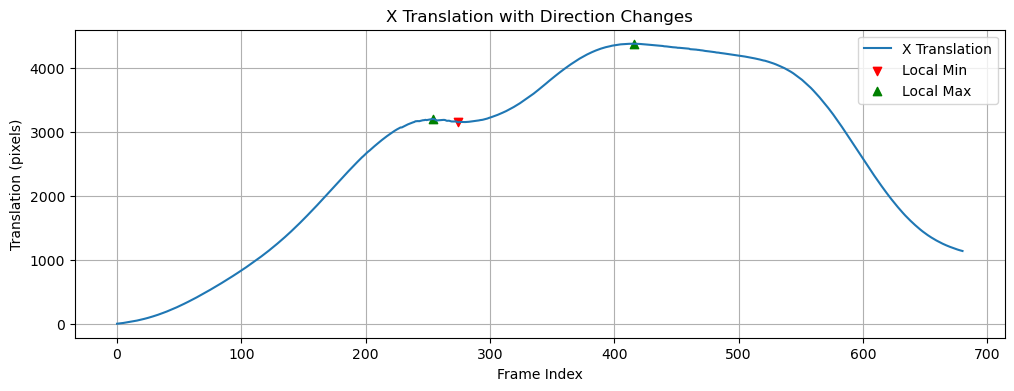

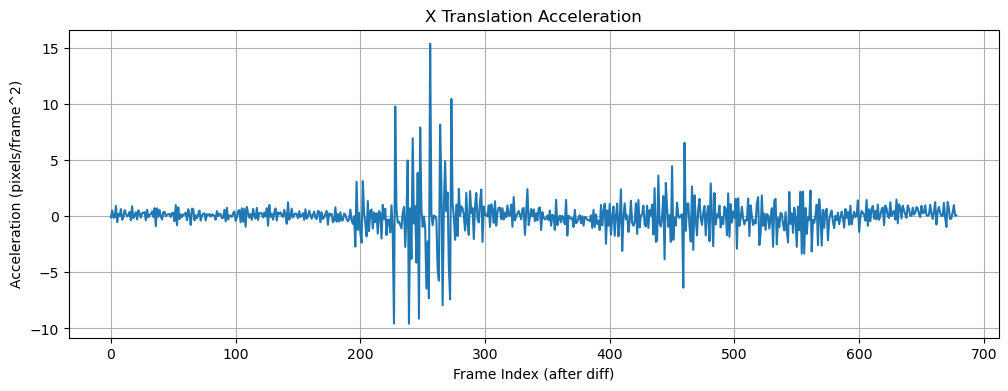

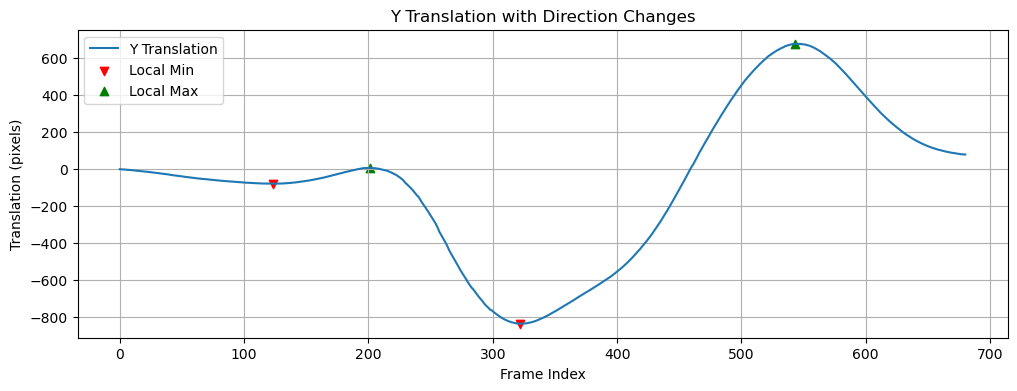

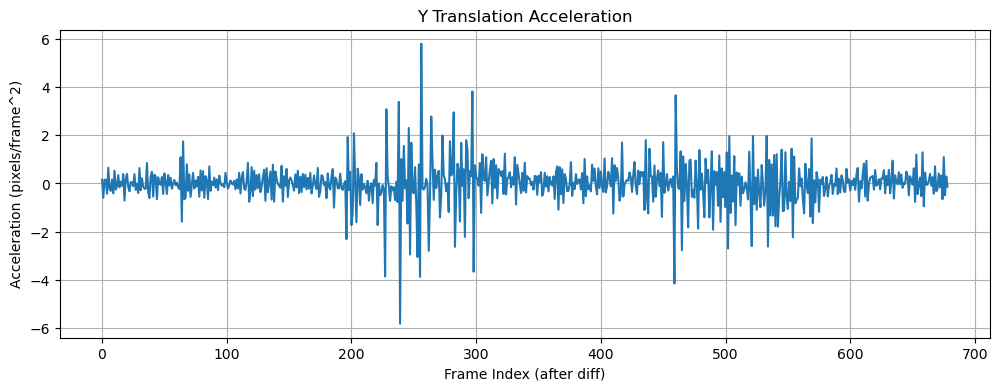

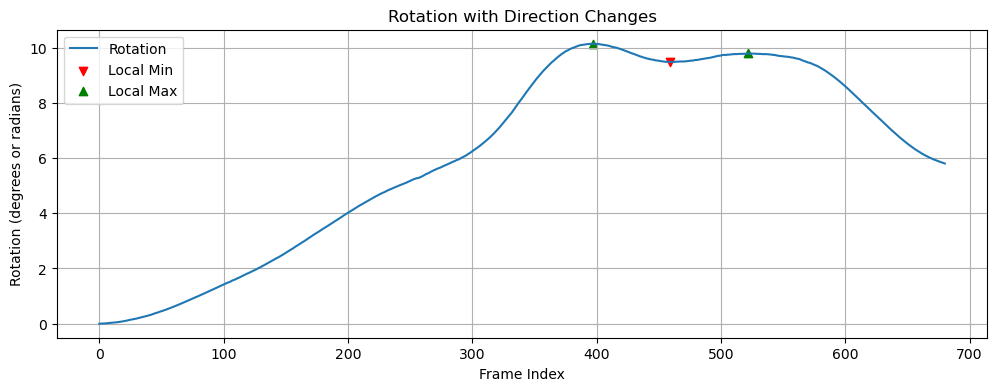

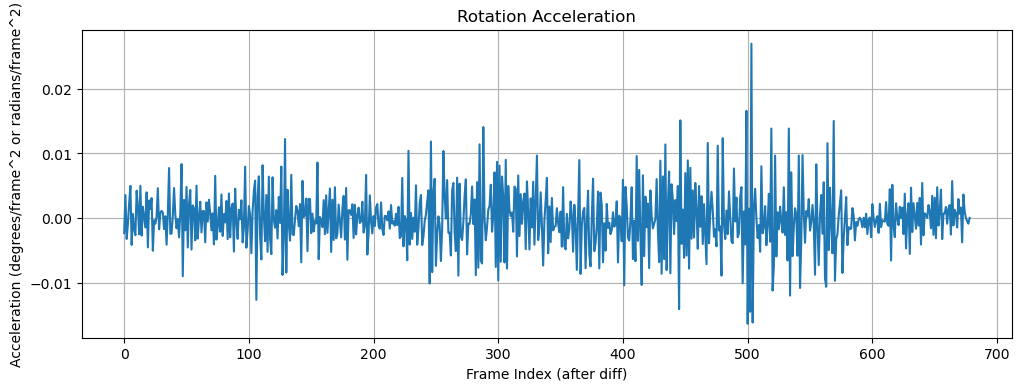

In [27]:
# Change this to control the neighborhood size for extrema detection
order = 10

# Function to find local minima and maxima
def find_extrema(arr):
    local_max = argrelextrema(arr, np.greater, order=order)[0]
    local_min = argrelextrema(arr, np.less, order=order)[0]
    return local_min, local_max

# Find extrema for all 3 vectors
x_min, x_max = find_extrema(x_translation)
y_min, y_max = find_extrema(y_translation)
rot_min, rot_max = find_extrema(rotation)

print("x_min:", x_min)
print("x_max:", x_max)
print("y_min:", y_min)
print("y_max:", y_max)
print("rot_min:", rot_min)
print("rot_max:", rot_max)

# Calculate first and second derivatives (velocity and acceleration)
dx = np.diff(x_translation)  # First derivative (velocity)
dy = np.diff(y_translation)  # First derivative (velocity)
rotation_diff = np.diff(rotation)  # Rotation change

# Second derivatives (acceleration)
ddx = np.diff(dx)  # Second derivative (acceleration)
ddy = np.diff(dy)  # Second derivative (acceleration)
rotation_acc = np.diff(rotation_diff)  # Rotation acceleration

# Plot X Translation with Acceleration
plt.figure(figsize=(12, 4))
plt.plot(x_translation, label='X Translation')
plt.scatter(x_min, x_translation[x_min], marker='v', color='red', label='Local Min')
plt.scatter(x_max, x_translation[x_max], marker='^', color='green', label='Local Max')
plt.title("X Translation with Direction Changes")
plt.xlabel("Frame Index")
plt.ylabel("Translation (pixels)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Acceleration of X Translation
plt.figure(figsize=(12, 4))
plt.plot(ddx, label='X Translation Acceleration')
plt.title("X Translation Acceleration")
plt.xlabel("Frame Index (after diff)")
plt.ylabel("Acceleration (pixels/frame^2)")
plt.grid(True)
plt.show()

# Plot Y Translation with Acceleration
plt.figure(figsize=(12, 4))
plt.plot(y_translation, label='Y Translation')
plt.scatter(y_min, y_translation[y_min], marker='v', color='red', label='Local Min')
plt.scatter(y_max, y_translation[y_max], marker='^', color='green', label='Local Max')
plt.title("Y Translation with Direction Changes")
plt.xlabel("Frame Index")
plt.ylabel("Translation (pixels)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Acceleration of Y Translation
plt.figure(figsize=(12, 4))
plt.plot(ddy, label='Y Translation Acceleration')
plt.title("Y Translation Acceleration")
plt.xlabel("Frame Index (after diff)")
plt.ylabel("Acceleration (pixels/frame^2)")
plt.grid(True)
plt.show()

# Plot Rotation with Acceleration
plt.figure(figsize=(12, 4))
plt.plot(rotation, label='Rotation')
plt.scatter(rot_min, rotation[rot_min], marker='v', color='red', label='Local Min')
plt.scatter(rot_max, rotation[rot_max], marker='^', color='green', label='Local Max')
plt.title("Rotation with Direction Changes")
plt.xlabel("Frame Index")
plt.ylabel("Rotation (degrees or radians)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Rotation Acceleration
plt.figure(figsize=(12, 4))
plt.plot(rotation_acc, label='Rotation Acceleration')
plt.title("Rotation Acceleration")
plt.xlabel("Frame Index (after diff)")
plt.ylabel("Acceleration (degrees/frame^2 or radians/frame^2)")
plt.grid(True)
plt.show()

[np.int64(0), np.int64(123), np.int64(201), np.int64(254), np.int64(274), np.int64(322), np.int64(397), np.int64(416), np.int64(459), np.int64(522), np.int64(543), np.int64(680)]
[INFO] Cumulative Homography from frame 0 to frame 0:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[INFO] Cumulative Homography from frame 0 to frame 123:
[[ 1.09954519e+00 -1.10312050e-02 -1.15623848e+03]
 [ 3.64632356e-02  1.04939019e+00  7.83179089e+01]
 [ 3.11797660e-05 -3.12660666e-06  9.82479689e-01]]

[INFO] Cumulative Homography from frame 0 to frame 201:
[[ 1.18225355e+00 -1.75664686e-02 -2.67264125e+03]
 [ 8.36166521e-02  1.10957946e+00 -8.20262157e+00]
 [ 7.12141949e-05 -8.97133174e-06  9.15740574e-01]]

[INFO] Cumulative Homography from frame 0 to frame 254:
[[ 1.16672533e+00 -1.91500901e-02 -3.19948955e+03]
 [ 1.07185684e-01  1.07383650e+00  2.93447809e+02]
 [ 8.48130978e-05 -3.65582979e-05  8.74526906e-01]]

[INFO] Cumulative Homography from frame 0 to frame 274:
[[ 1.12097479e+00 -1.31267603e-02 -3.148

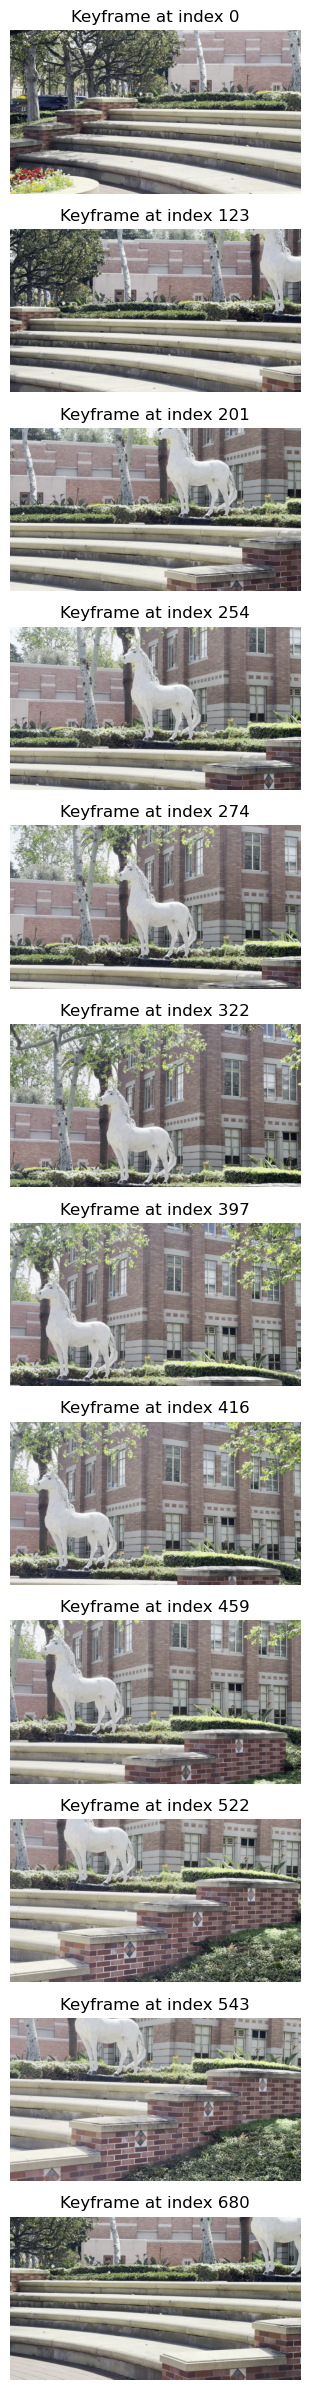

In [30]:
cap = cv2.VideoCapture(video_path)

# Combine all indices (optional: remove duplicates and sort)
last_index = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
keyframe_indices = sorted(set(np.concatenate([[0], [last_index],x_min, x_max, y_min, y_max, rot_min, rot_max])))
print(keyframe_indices)

# Load video
cap = cv2.VideoCapture(video_path)

def get_frame(index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    if not ret:
        print(f"[ERROR] Could not retrieve frame {index}")
        return None
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

# Display selected keyframes inline
plt.figure(figsize=(15, len(keyframe_indices) * 2))
for i, idx in enumerate(keyframe_indices):
    frame = get_frame(idx)
    if frame is not None:
        plt.subplot(len(keyframe_indices), 1, i+1)
        plt.imshow(frame)
        plt.title(f'Keyframe at index {idx}')
        plt.axis('off')
cap.release()
plt.tight_layout()
plt.show()



In [31]:
def describe_homography(H):
    dx = H[0, 2]
    dy = H[1, 2]
    
    # Approximate rotation angle
    rotation_rad = math.atan2(H[1, 0], H[0, 0])
    rotation_deg = np.degrees(rotation_rad)

    # Approximate scale factors
    scale_x = np.linalg.norm(H[0, :2])
    scale_y = np.linalg.norm(H[1, :2])

    # Generate readable summary
    motion_description = f"Translation: dx = {dx:.2f}, dy = {dy:.2f}\n" \
                         f"Rotation: {rotation_deg:.2f}°\n" \
                         f"Scale: x = {scale_x:.2f}, y = {scale_y:.2f}"
    return motion_description

# Display all
for idx in keyframe_indices:
    H = cumulative_homographies[idx]
    print(f"[INFO] Frame 0 → Frame {idx}")
    print(describe_homography(H))
    print("Homography Matrix:")
    print(H)
    print("-" * 60)

[INFO] Frame 0 → Frame 0
Translation: dx = 0.00, dy = 0.00
Rotation: 0.00°
Scale: x = 1.00, y = 1.00
Homography Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
------------------------------------------------------------
[INFO] Frame 0 → Frame 123
Translation: dx = -1156.24, dy = 78.32
Rotation: 1.90°
Scale: x = 1.10, y = 1.05
Homography Matrix:
[[ 1.09954519e+00 -1.10312050e-02 -1.15623848e+03]
 [ 3.64632356e-02  1.04939019e+00  7.83179089e+01]
 [ 3.11797660e-05 -3.12660666e-06  9.82479689e-01]]
------------------------------------------------------------
[INFO] Frame 0 → Frame 201
Translation: dx = -2672.64, dy = -8.20
Rotation: 4.05°
Scale: x = 1.18, y = 1.11
Homography Matrix:
[[ 1.18225355e+00 -1.75664686e-02 -2.67264125e+03]
 [ 8.36166521e-02  1.10957946e+00 -8.20262157e+00]
 [ 7.12141949e-05 -8.97133174e-06  9.15740574e-01]]
------------------------------------------------------------
[INFO] Frame 0 → Frame 254
Translation: dx = -3199.49, dy = 293.45
Rotation: 5.25°
Scale: x = 1.17

In [46]:
cap = cv2.VideoCapture(video_path)

# Initialize SIFT with more features

# Read only the keyframes we need
frames = {}
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count in keyframe_indices:
        print(frame_count)
        frames[frame_count] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_count += 1
cap.release()


0
123
201
254
274
322
397
416
459
522
543
680


681
681
[DEBUG] Frame 0:
    Warped corner 0: (0.00, 0.00)
    Warped corner 1: (3840.00, 0.00)
    Warped corner 2: (3840.00, 2160.00)
    Warped corner 3: (0.00, 2160.00)
[DEBUG] Frame 1:
    Warped corner 0: (-2.21, 0.33)
    Warped corner 1: (3837.20, 0.57)
    Warped corner 2: (3837.63, 2160.45)
    Warped corner 3: (-2.28, 2160.92)
[DEBUG] Frame 2:
    Warped corner 0: (-4.31, 0.52)
    Warped corner 1: (3834.16, 0.83)
    Warped corner 2: (3836.38, 2161.72)
    Warped corner 3: (-6.86, 2161.93)
[DEBUG] Frame 3:
    Warped corner 0: (-6.93, 1.30)
    Warped corner 1: (3831.82, 1.92)
    Warped corner 2: (3834.57, 2161.69)
    Warped corner 3: (-8.24, 2162.56)
[DEBUG] Frame 4:
    Warped corner 0: (-9.40, 1.92)
    Warped corner 1: (3828.68, 2.65)
    Warped corner 2: (3832.85, 2162.22)
    Warped corner 3: (-11.06, 2163.80)
[DEBUG] Frame 5:
    Warped corner 0: (-11.78, 2.40)
    Warped corner 1: (3826.83, 3.17)
    Warped corner 2: (3828.23, 2161.89)
    Warped corner 3: (-13.50

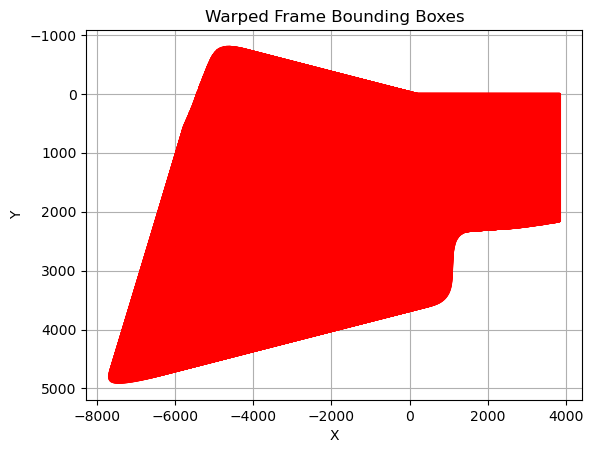

[INFO] Canvas size: 11532x5702, Offset: (7692, 796)
[INFO] Warped frame 0 into panorama
[INFO] Warped frame 1 into panorama
[INFO] Warped frame 2 into panorama
[INFO] Warped frame 3 into panorama
[INFO] Warped frame 4 into panorama
[INFO] Warped frame 5 into panorama
[INFO] Warped frame 6 into panorama
[INFO] Warped frame 7 into panorama
[INFO] Warped frame 8 into panorama
[INFO] Warped frame 9 into panorama
[INFO] Warped frame 10 into panorama
[INFO] Warped frame 11 into panorama
[INFO] Warped frame 12 into panorama
[INFO] Warped frame 13 into panorama
[INFO] Warped frame 14 into panorama
[INFO] Warped frame 15 into panorama
[INFO] Warped frame 16 into panorama
[INFO] Warped frame 17 into panorama
[INFO] Warped frame 18 into panorama
[INFO] Warped frame 19 into panorama
[INFO] Warped frame 20 into panorama
[INFO] Warped frame 21 into panorama
[INFO] Warped frame 22 into panorama
[INFO] Warped frame 23 into panorama
[INFO] Warped frame 24 into panorama
[INFO] Warped frame 25 into panor

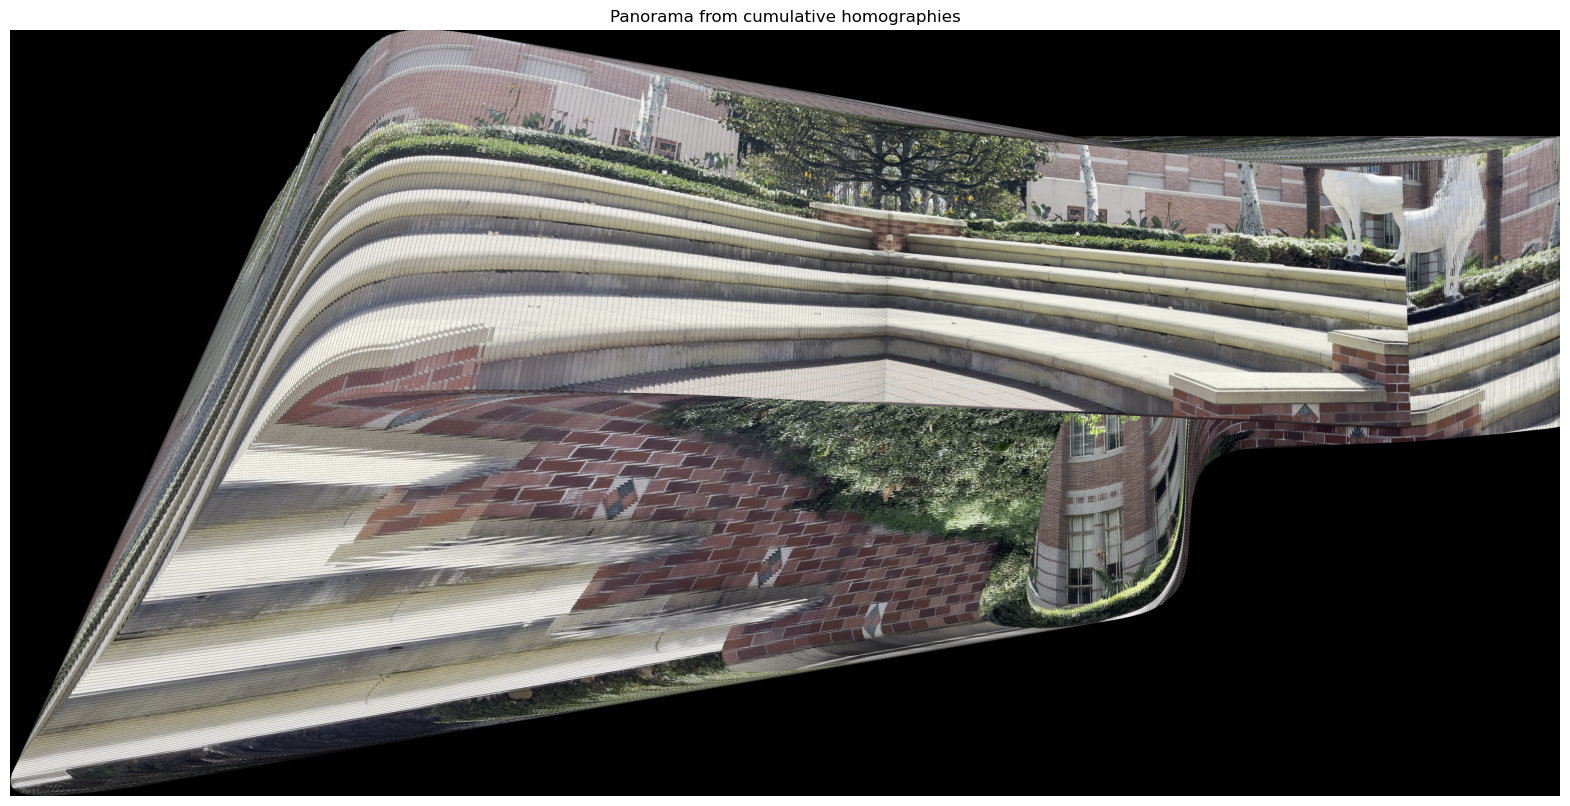

In [100]:
print(len(frames))
print(len(cumulative_homographies))


def compute_canvas_bounds(frames_dict, homographies):
    corners = []
    h, w = next(iter(frames_dict.values())).shape[:2]
    for idx, H in enumerate(homographies):
        frame_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(frame_corners, H)
        corners.append(warped_corners.reshape(-1, 2))
    
        print(f"[DEBUG] Frame {idx}:")
        for i, (x, y) in enumerate(warped_corners.reshape(-1,2)):
            print(f"    Warped corner {i}: ({x:.2f}, {y:.2f})")
    
    all_corners = np.concatenate(corners, axis=0)
    min_x, min_y = np.floor(all_corners.min(axis=0)).astype(int)
    max_x, max_y = np.ceil(all_corners.max(axis=0)).astype(int)

    print(f"[DEBUG] Panorama bounding box:")
    print(f"    min_x = {min_x}, min_y = {min_y}")
    print(f"    max_x = {max_x}, max_y = {max_y}")

    for warped in corners:
        xs, ys = warped[:, 0], warped[:, 1]
        plt.plot(xs.tolist() + [xs[0]], ys.tolist() + [ys[0]], 'r-')  # close the quadrilateral
    
    plt.title("Warped Frame Bounding Boxes")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.gca().invert_yaxis()  # Optional: if your image coordinates treat top as 0
    plt.show()

    return min_x, min_y, max_x, max_y

def warp_and_stitch(frames_dict, homographies):
    min_x, min_y, max_x, max_y = compute_canvas_bounds(frames_dict, homographies)

    # Canvas size and translation
    width = max_x - min_x
    height = max_y - min_y
    offset = np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]], dtype=np.float64)

    print(f"[INFO] Canvas size: {width}x{height}, Offset: ({-min_x}, {-min_y})")

    canvas = np.zeros((height, width, 3), dtype=np.uint8)

    for idx, frame in frames_dict.items():
        H = homographies[idx]
        H_offset = offset @ H

        warped = cv2.warpPerspective(frame, H_offset, (width, height))
        mask = (cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY) > 0)

        canvas[mask] = warped[mask]
        print(f"[INFO] Warped frame {idx} into panorama")
    return canvas

stitched_image = warp_and_stitch(frames, cumulative_homographies)

# Display using matplotlib
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Panorama from cumulative homographies")
plt.show()

In [49]:
sift = cv2.SIFT_create(nfeatures=5000)
bf = cv2.BFMatcher()
# Compute cumulative homographies
homographies = [np.eye(3)]
frame_indices = [keyframe_indices[0]]

for i in range(1, len(keyframe_indices)):
    idx_prev = keyframe_indices[i - 1]
    idx_curr = keyframe_indices[i]

    img1 = frames[idx_prev]
    img2 = frames[idx_curr]

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    print(f"[INFO] Frame {idx_prev} → {idx_curr}: {len(good_matches)} good matches")

    if len(good_matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

        if H is not None:
            cumulative_sub_H = homographies[-1] @ H
            homographies.append(cumulative_sub_H)
            frame_indices.append(idx_curr)
            print(f"[✓] Cum H from frame 0 to {idx_curr}:\n{cumulative_sub_H}")
        else:
            print(f"[✗] Homography estimation failed for {idx_prev} → {idx_curr}")
    else:
        print(f"[✗] Not enough matches for {idx_prev} → {idx_curr}")

[INFO] Frame 0 → 123: 755 good matches
[✓] Cum H from frame 0 to 123:
[[ 1.11957382e+00 -7.05333601e-03 -1.17475185e+03]
 [ 3.92168622e-02  1.07826722e+00  7.16307561e+01]
 [ 3.18670345e-05  2.38636231e-06  1.00000000e+00]]
[INFO] Frame 123 → 201: 688 good matches
[✓] Cum H from frame 0 to 201:
[[ 1.25285940e+00 -1.67204234e-02 -2.82440199e+03]
 [ 9.81807108e-02  1.18232388e+00 -3.94551731e+01]
 [ 8.12059442e-05 -4.68060769e-06  9.52917258e-01]]
[INFO] Frame 201 → 254: 1554 good matches
[✓] Cum H from frame 0 to 254:
[[ 1.27351108e+00 -1.91407710e-02 -3.47829659e+03]
 [ 1.29759795e-01  1.20629817e+00  2.46827215e+02]
 [ 1.00355354e-04 -1.60096629e-05  9.09508431e-01]]
[INFO] Frame 254 → 274: 1627 good matches
[✓] Cum H from frame 0 to 274:
[[ 1.31692945e+00 -6.96486701e-02 -3.60350820e+03]
 [ 1.42948752e-01  1.32899937e+00  4.10070631e+02]
 [ 1.06483439e-04  2.08289512e-06  8.97529134e-01]]
[INFO] Frame 274 → 322: 1333 good matches
[✓] Cum H from frame 0 to 322:
[[ 1.31276376e+00 -7.29

In [50]:
# Display all
for i, idx in enumerate(keyframe_indices):
    H = homographies[i]
    H_og = cumulative_homographies[idx]
    print(f"[INFO] Frame 0 → Frame {idx}")
    print("Subset Recompute:", describe_homography(H))
    print("Original:", describe_homography(H_og))
    print("Subset Homography Matrix:")
    print(H)
    print("Original Homography Matrix:")
    print(H_og)
    print("-" * 60)

[INFO] Frame 0 → Frame 0
Subset Recompute: Translation: dx = 0.00, dy = 0.00
Rotation: 0.00°
Scale: x = 1.00, y = 1.00
Original: Translation: dx = 0.00, dy = 0.00
Rotation: 0.00°
Scale: x = 1.00, y = 1.00
Subset Homography Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Original Homography Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
------------------------------------------------------------
[INFO] Frame 0 → Frame 123
Subset Recompute: Translation: dx = -1174.75, dy = 71.63
Rotation: 2.01°
Scale: x = 1.12, y = 1.08
Original: Translation: dx = -1156.24, dy = 78.32
Rotation: 1.90°
Scale: x = 1.10, y = 1.05
Subset Homography Matrix:
[[ 1.11957382e+00 -7.05333601e-03 -1.17475185e+03]
 [ 3.92168622e-02  1.07826722e+00  7.16307561e+01]
 [ 3.18670345e-05  2.38636231e-06  1.00000000e+00]]
Original Homography Matrix:
[[ 1.09954519e+00 -1.10312050e-02 -1.15623848e+03]
 [ 3.64632356e-02  1.04939019e+00  7.83179089e+01]
 [ 3.11797660e-05 -3.12660666e-06  9.82479689e-01]]
---------------------------

In [89]:
cap = cv2.VideoCapture(video_path)
# === Load frames from video ===
frames = {}
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count in range(len(cumulative_homographies)):
        frames[frame_count] = frame
    print(frame_count)
    frame_count += 1
    
cap.release()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [68]:
print([int(f) for f in frame_indices])

[0, 123, 201, 254, 274, 322, 397, 416, 459, 522, 543, 680]


In [69]:
from typing import List, Tuple

class GrowableCanvas:
    """Manages the growing canvas for stitching frames."""

    def __init__(self):
        self.frames_data: List[Tuple[np.ndarray, np.ndarray]] = []  # Store (frame, H_cum)
        self.min_x, self.min_y = 0.0, 0.0
        self.max_x, self.max_y = 0.0, 0.0
        self.initialized = False # Added flag
        self.canvas = None
        self.final_mask = None
        self.prev_frame_count = 0
        self.H_finals = []

    def _update_bounds(self, frame: np.ndarray, H_cum: np.ndarray): # Changed M_abs to H_cum
        """Update canvas bounds using perspective transform on corners.""" # Changed docstring
        h, w = frame.shape[:2]
        corners = np.array([
            [0, 0], [w, 0], [w, h], [0, h]
        ], dtype=np.float32)
        corners_reshaped = corners.reshape(-1, 1, 2) # Reshape for perspectiveTransform

        # Apply the cumulative homography H_cum (must be 3x3)
        if H_cum is None or H_cum.shape != (3, 3):
             print("Warning: Invalid H_cum matrix in _update_bounds. Skipping bounds update.")
             transformed_corners = corners_reshaped # Use original corners if transform invalid
        else:
            try:
                # Use perspectiveTransform instead of transform
                transformed_corners = cv2.perspectiveTransform(corners_reshaped, H_cum)
                if transformed_corners is None: # perspectiveTransform can fail
                    print("Warning: cv2.perspectiveTransform returned None. Using original corners.")
                    transformed_corners = corners_reshaped
            except cv2.error as e:
                print(f"Error during perspectiveTransform: {e}. Using original corners.")
                transformed_corners = corners_reshaped

        # Extract x, y coordinates.
        cx = transformed_corners[:, 0, 0]
        cy = transformed_corners[:, 0, 1]

        current_min_x = np.min(cx)
        current_min_y = np.min(cy)
        current_max_x = np.max(cx)
        current_max_y = np.max(cy)

        if not self.initialized:  # Use initialized flag
            self.min_x, self.min_y = current_min_x, current_min_y
            self.max_x, self.max_y = current_max_x, current_max_y
            self.initialized = True # Set flag on first successful update
        else:
            self.min_x = min(self.min_x, current_min_x)
            self.min_y = min(self.min_y, current_min_y)
            self.max_x = max(self.max_x, current_max_x)
            self.max_y = max(self.max_y, current_max_y)

    def add(self, frame: np.ndarray, H_cum: np.ndarray): # Changed M_abs to H_cum
        """Add a frame and its cumulative homography matrix."""
        if H_cum is not None and H_cum.shape == (3, 3):
            # Update bounds *before* adding, so initialization flag works correctly
            self._update_bounds(frame, H_cum)
            self.frames_data.append((frame.copy(), H_cum.copy()))
        else:
            print("Warning: Attempted to add frame with invalid H_cum. Frame skipped.")


    def get_final_image2(self) -> np.ndarray:
        """Incrementally build the stitched panorama using perspective warping."""
        if not self.frames_data:
            return np.zeros((100, 100, 3), dtype=np.uint8)

        # Calculate the size of the final canvas
        final_w = int(np.ceil(self.max_x - self.min_x))
        final_h = int(np.ceil(self.max_y - self.min_y))
        final_w = max(final_w, 1)
        final_h = max(final_h, 1)

        # Translation matrix to shift everything to positive coordinates
        T = np.array([
            [1, 0, -self.min_x],
            [0, 1, -self.min_y],
            [0, 0, 1]
        ], dtype=np.float64)

        # Initialize canvas and mask once
        if self.canvas is None or self.canvas.shape[:2] != (final_h, final_w):
            self.canvas = np.zeros((final_h, final_w, 3), dtype=np.uint8)
            self.final_mask = np.zeros((final_h, final_w), dtype=np.uint8)
            self.prev_frame_count = 0  # Reset if canvas size changes
        print(self.prev_frame_count)
        for i in range(self.prev_frame_count, len(self.frames_data)):
            frame, H_cum = self.frames_data[i]
            H_final = T @ H_cum

            self.H_finals.append(H_final)

            frame_indices = [0, 123, 201, 254, 274, 322, 397, 416, 459, 522, 543, 680]
            if i in frame_indices:
                try:
                    print(f"H_final for frame {i}", H_final)
                    warped_frame = cv2.warpPerspective(frame, H_final, (final_w, final_h),
                                                       flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT)
                    frame_mask = np.ones(frame.shape[:2], dtype=np.uint8) * 255
                    warped_mask = cv2.warpPerspective(frame_mask, H_final, (final_w, final_h),
                                                      flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT) > 0


                    update_pixels = (self.final_mask == 0) & warped_mask

                    self.canvas[update_pixels] = warped_frame[update_pixels]
                    self.final_mask[update_pixels] = 1

                    print(f"Incremental warp: frame {i+1}/{len(self.frames_data)}")
                except cv2.error as e:
                    print(f"Error warping frame {i}: {e}")
        
        self.prev_frame_count = len(self.frames_data)
        print(self.prev_frame_count)
        return self.canvas.copy()

In [86]:
import random

# Load video again to extract missing frames
cap = cv2.VideoCapture(video_path)

# Dictionary to store selected frames
selected_frames = {idx: cap.read()[1] for idx in frame_indices}  # Assume frames are already loaded

def add_interpolated_frames(frame_indices, selected_frames, cap, num_equally_spaced=5):
    import math
    new_selected_frames = selected_frames.copy()

    for i in range(len(frame_indices) - 1):
        start_idx, end_idx = frame_indices[i], frame_indices[i + 1]
        gap = end_idx - start_idx

        if gap <= 1:
            continue  # No room to add intermediate frames

        # Compute interpolated frame indices
        step = gap / (num_equally_spaced + 1)
        interpolated_indices = [int(round(start_idx + step * j)) for j in range(1, num_equally_spaced + 1)]

        for idx in interpolated_indices:
            if idx in new_selected_frames:
                continue  # Avoid duplicates

            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                new_selected_frames[idx] = frame
                print(f"[INFO] Added interpolated frame {idx} between {start_idx} and {end_idx}")
            else:
                print(f"[WARNING] Could not read frame {idx}")

    return new_selected_frames

# Add up to 5 random frames between the subset
updated_selected_frames = add_interpolated_frames(frame_indices, s, num_random=5)

# Sort the frames by index again to maintain order
updated_selected_frames = dict(sorted(updated_selected_frames.items()))

# Now you can use updated_selected_frames for stitching or further processing
print(f"[INFO] Total frames after adding random ones: {len(updated_selected_frames)}")

TypeError: add_interpolated_frames() got an unexpected keyword argument 'num_random'

In [85]:
print([int(i) for i in list(updated_selected_frames.keys())])

[0, 1, 42, 98, 109, 112, 123, 135, 144, 152, 155, 191, 201, 203, 214, 215, 222, 223, 254, 258, 262, 266, 270, 271, 274, 281, 287, 289, 292, 306, 322, 332, 336, 343, 349, 382, 397, 402, 403, 405, 411, 412, 416, 419, 423, 446, 453, 455, 459, 477, 480, 512, 516, 518, 522, 528, 532, 533, 534, 535, 543, 592, 602, 616, 638, 643, 680]


In [1]:
import cv2
import matplotlib.pyplot as plt
print(frames.keys())
# Ensure frames are sorted by index
sorted_indices = sorted(.keys())
frames_list = [updated_selected_frames[idx] for idx in sorted_indices]
print(len(frames_list))
# Initialize the Stitcher
stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)

print("[INFO] Stitching panorama using cv2.Stitcher...")
status, stitched = stitcher.stitch(frames_list)

if status == cv2.Stitcher_OK:
    print("[INFO] Panorama stitching successful.")
    
    # Convert from BGR (OpenCV default) to RGB for matplotlib
    stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 10))
    plt.imshow(stitched_rgb)
    plt.title("Stitched Panorama")
    plt.axis("off")
    plt.show()
else:
    print(f"[ERROR] Stitching failed with status code {status}.")

SyntaxError: invalid syntax (3442317057.py, line 5)